In [391]:
import geopandas as gpd
import pandas as pd
pd.options.display.max_columns = None
import statsmodels.api as sm
import zipfile

import numpy as np

# read in the shapefile of buncome parcels
parcels = gpd.read_file("./data/Buncombe_County_Parcels/Buncombe_County_Parcels.zip") 
print(parcels.columns)
print(len(parcels))
# read in the CSV file 
zf = zipfile.ZipFile('./data/Appraisal_Tax_History2022/Real_Estate_Appraisal_Tax_History_2022.zip') 
appraisal_tax_history = pd.read_csv(zf.open('Real_Estate_Appraisal_Tax_History_2022.csv'))

# appraisal_tax_history = pd.read_csv("./data/Appraisal_Tax_History2022/Real_Estate_Appraisal_Tax_History_2022.zip",compression='zip') 
print(len(appraisal_tax_history))


Index(['PIN', 'Owner', 'NmpType', 'TaxYear', 'CondoUnit', 'CondoBuild',
       'DeedBook', 'DeedPage', 'PlatBook', 'PlatPage', 'SubName', 'SubLot',
       'SubBlock', 'SubSect', 'UpdateDate', 'HouseNumbe', 'NumberSuff',
       'StreetName', 'StreetType', 'Township', 'Acreage', 'AccountNum',
       'DeedDate', 'Stamps', 'Instrument', 'Reason', 'County', 'City',
       'FireDistri', 'SchoolDist', 'CareOf', 'Address', 'CityName', 'State',
       'Zipcode', 'Class', 'Improved', 'Exempt', 'Priced', 'TotalMarke',
       'AppraisedV', 'TaxValue', 'LandUse', 'Neighborho', 'LandValue',
       'BuildingVa', 'AppraisalA', 'PropCard', 'StreetPref', 'StreetPost',
       'SalePrice', 'objectid', 'ESRI_OID', 'geometry'],
      dtype='object')
131856


/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/840337364.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  appraisal_tax_history = pd.read_csv(zf.open('Real_Estate_Appraisal_Tax_History_2022.csv'))


2491791


In [392]:
# Single family
# 'RES 0-3 ACRES', 'RES >3 ACRES', 'CONDO','TOWNHOME', 'MFG HOME SITE'
parcels =parcels.loc[parcels['Class'].isin(['100','101','120','121','170'])]
print(len(parcels))
parcels_len=len(parcels)

91179


In [393]:
#  For now I'm justing looking a the percent change from 2020 to 2021
appraisal_tax_history = appraisal_tax_history.loc[appraisal_tax_history['TaxYear'] >= 2020]

# Filtering for tax history records that have a PIN in the parcel database
# this might help with computation load for the merge we'll do later
appraisal_tax_history = appraisal_tax_history[appraisal_tax_history['PIN'].isin(parcels['PIN'])] 

# Calculating total valuation from land and bldg valuation. 
appraisal_tax_history['TotalVal'] = appraisal_tax_history['LandVal']+appraisal_tax_history['BldgVal']

#calculate percent change
appraisal_tax_history = appraisal_tax_history.sort_values(by=['PIN','TaxYear'])
appraisal_tax_history['land_value_pct_change'] = appraisal_tax_history.groupby('PIN')['LandVal'].pct_change(periods=1)
appraisal_tax_history['building_value_pct_change'] = appraisal_tax_history.groupby('PIN')['BldgVal'].pct_change(periods=1) 
appraisal_tax_history['total_value_pct_change'] = appraisal_tax_history.groupby('PIN')['TotalVal'].pct_change(periods=1) 


In [394]:
appraisal_tax_history = appraisal_tax_history.loc[appraisal_tax_history['TaxYear'] == 2021.0]
print(len(appraisal_tax_history))

83280


In [395]:

# User inner join here to only anlayse properties that I have a rate change for
# this is to avoid possible parcels that have been recently created, so i don't peg them as having not 
# paid a bill without having been around for the rate increase
merged_data = parcels.merge(appraisal_tax_history, how='inner', left_on='PIN', right_on='PIN')
print(len(merged_data))

merged_data_length_with_percent_change = len(merged_data)
merged_data.head(2)

83280


,PIN,Owner,NmpType,TaxYear_x,CondoUnit,CondoBuild,DeedBook,DeedPage,PlatBook,PlatPage,SubName,SubLot,SubBlock,SubSect,UpdateDate,HouseNumbe,NumberSuff,StreetName,StreetType,Township,Acreage,AccountNum,DeedDate,Stamps,Instrument,Reason,County,City,FireDistri,SchoolDist,CareOf,Address,CityName,State,Zipcode,Class,Improved,Exempt,Priced,TotalMarke,AppraisedV,TaxValue,LandUse,Neighborho,LandValue,BuildingVa,AppraisalA,PropCard,StreetPref,StreetPost,SalePrice,objectid,ESRI_OID,geometry,TaxYear_y,PinOwner,Acres,LandVal,BldgVal,ImprVal,ExemVal,DfrdVal,Exemption,OBJECTID,TotalVal,land_value_pct_change,building_value_pct_change,total_value_pct_change
0,060503100000000,STONE ROBERT K;STONE REBECCA,NaN,24,None,None,1340,0496,0000,0000,None,None,None,None,20230117,23,None,BUTTERROW COVE,RD,20,1.69,69436531;69436532,19710706,1.0,DEE,None,BUN,None,FFA,None,None,23 BUTTERROW COVE RD,FAIRVIEW,NC,28730,100,Y,None,None,296000,296000,296000,None,TSTD,61100,233900,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,1000,121558,74153,"POLYGON ((-82.36073 35.49799, -82.36057 35.497...",2021.0,69436531.0,1.69,61100.0,233900.0,1000.0,0.0,0.0,0,59,295000.0,0.0,0.096064,0.074681
1,060503128800000,MOLLY HAMILTON TRUST,NaN,24,None,None,6282,559,0104,0149,SUGAR HOLLOW ORCHARDS,3,None,None,20230117,5,None,SUGAR HOLLOW ORCHARD,DR,20,1.50,82925343,20221212,0.0,WDT,None,BUN,None,FFA,None,None,5 SUGAR HOLLOW ORCHARD DR,FAIRVIEW,NC,28730,100,Y,None,None,474200,474200,474200,None,SUOA,120000,354200,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,0,76153,74154,"POLYGON ((-82.35906 35.49882, -82.35946 35.498...",2021.0,82248521.0,1.50,120000.0,354200.0,0.0,0.0,0.0,0,75,474200.0,0.0,0.095238,0.069463


In [396]:

unpaid_bills = pd.read_csv("./data/Unpaid_Property_Bills2022/Unpaid_Property_Bills_from_2022.csv")
# This will help identify properties with an unpaid bill, after merging the data.
unpaid_bills['unpaid_bill']=True

print(len(unpaid_bills))
print(len(merged_data))
print(len(parcels))


# Remove leading and trailing white spaces from the "address_line1", "city", "postal_code", "ADDRESS", "CITYNAME", and "ZIPCODE" columns


unpaid_bills = unpaid_bills.rename(columns={'pin': 'PIN'})
# unpaid_bills['PIN'] = unpaid_bills['PIN'].astype(object)
# merged_data['PIN'] = merged_data['PIN'].astype(object)
# parcels['PIN'] = parcels['PIN'].astype(object)




# unpaid_bills['PIN'] = unpaid_bills['PIN'].astype(int)
# merged_data['PIN'] = merged_data['PIN'].astype(int)
# parcels['PIN'] = parcels['PIN'].astype(int)


unpaid_bills['PIN'] = unpaid_bills['PIN'].astype(str)
merged_data['PIN'] = merged_data['PIN'].astype(str)
parcels['PIN'] = parcels['PIN'].astype(str)


unpaid_bills['PIN'] = unpaid_bills['PIN'].str.replace("-", "")


unpaid_bills['PIN'] = unpaid_bills['PIN'].str.strip()
merged_data['PIN'] = merged_data['PIN'].str.strip()
parcels['PIN'] = parcels['PIN'].str.strip()

unpaid_bills['PIN'] = unpaid_bills['PIN'].fillna(value='')
merged_data['PIN'] = merged_data['PIN'].fillna(value='')
parcels['PIN'] = parcels['PIN'].fillna(value='')



print(len(merged_data))
print('unpaid_bills: ',len(unpaid_bills))

print( unpaid_bills['PIN'].dtype)
print(merged_data['PIN'].dtype)
print( parcels['PIN'].dtype)

# Sort the dataframes on the join column "PIN"
merged_data.sort_values("PIN", inplace=True)
unpaid_bills.sort_values("PIN", inplace=True)
parcels.sort_values("PIN", inplace=True)



#merge left 
print("before merge: ", len(merged_data))
merged_data = merged_data.merge(unpaid_bills, how='left',on='PIN')
print("after merge: ", len(merged_data))

print("before parcel merge: ", len(parcels))
parcels = parcels.merge(unpaid_bills, how='left',on='PIN')
print("after parcel merge: ", len(parcels))


merged_data['unpaid_bill']=merged_data['unpaid_bill'].fillna(value=False)
parcels['unpaid_bill']=parcels['unpaid_bill'].fillna(value=False)

print(merged_data['unpaid_bill'].value_counts(dropna=False))
print(parcels['unpaid_bill'].value_counts(dropna=False))

# merged_data = merged_data.join(unpaid_bills, how='left',on='PIN',
#                                lsuffix='', rsuffix='_y', sort=False)
# print(len(merged_data))

# parcels = parcels.join(unpaid_bills, how='left', on='PIN',
#                                lsuffix='', rsuffix='_y', sort=False)
# print(len(parcels))

# Originally I had thought to try a secondary merge on address columns,
# because there are many unpaid bills without a 'PIN'
# but a gentelman at the county GIS office told me that unpaid bills with
# a pin would be real-estate related, while thouse without it might be a 
# different type of property. Keeping this here to save the idea.

# unpaid_bills['pin'] = unpaid_bills['pin'].str.replace("-", "")
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].astype(str)
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].astype(object)

# print(merged_data[["Address", "CityName", "Zipcode"]].dtypes)
# print(merged_data['PIN'].dtype)
# print(unpaid_bills['pin'].dtype)
# print(unpaid_bills[["address_line1", "city", "postal_code"]].dtypes)
unpaid_bills['address_line1']=unpaid_bills['address_line1']+unpaid_bills['address_line2']
unpaid_bills['address_line1'] = unpaid_bills['address_line1'].str.strip()
unpaid_bills['city'] = unpaid_bills['city'].str.strip()
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].str.strip()
merged_data['Address'] = merged_data['Address'].str.strip()
merged_data['CityName'] = merged_data['CityName'].str.strip()
# merged_data['Zipcode'] = merged_data['Zipcode'].str.strip()

# # Convert the "address_line1", "city", "postal_code", "ADDRESS", "CITYNAME", and "ZIPCODE" columns to lowercase
unpaid_bills['address_line1'] = unpaid_bills['address_line1'].str.lower()
unpaid_bills['city'] = unpaid_bills['city'].str.lower()
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].str.lower()
merged_data['Address'] = merged_data['Address'].str.lower()
merged_data['CityName'] = merged_data['CityName'].str.lower()
# merged_data['Zipcode'] = merged_data['Zipcode'].str.lower()





print(parcels['unpaid_bill'].value_counts(dropna=False))

#Secondary merge on "Address", "CityName", "Zipcode" and "address_line1", "city", "postal_code"
print("before second merge: ", len(merged_data))
print("before second parcel merge: ", len(parcels))
merged_data = merged_data.merge(unpaid_bills, how='left', 
                                left_on=['Address', 'CityName'], 
                                right_on=['address_line1', 'city'],suffixes=['','_y'])


parcels = parcels.merge(unpaid_bills, how='left', 
                                left_on=['Address', 'CityName'], 
                                right_on=['address_line1', 'city'],suffixes=['','_y'])
print("after second merge: ", len(merged_data))

print("after second parcel merge: ", len(parcels))
# print(len(merged_data_no_pin))
# merged_data = pd.concat([merged_data_no_pin,merged_data]) 
merged_data['unpaid_bill']=merged_data['unpaid_bill'].fillna(value=False)
parcels['unpaid_bill']=parcels['unpaid_bill'].fillna(value=False)

print(merged_data['unpaid_bill'].value_counts(dropna=False))
print(parcels['unpaid_bill'].value_counts(dropna=False))

merged_data.head(2)

/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/1886915109.py:1: DtypeWarning: Columns (12,21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  unpaid_bills = pd.read_csv("./data/Unpaid_Property_Bills2022/Unpaid_Property_Bills_from_2022.csv")


21369
83280
91179
83280
unpaid_bills:  21369
object
object
object
before merge:  83280
after merge:  83319
before parcel merge:  91179
after parcel merge:  91224
False    77432
True      5887
Name: unpaid_bill, dtype: int64
False    84888
True      6336
Name: unpaid_bill, dtype: int64
False    84888
True      6336
Name: unpaid_bill, dtype: int64
before second merge:  83319
before second parcel merge:  91224
after second merge:  83319
after second parcel merge:  91224
False    77432
True      5887
Name: unpaid_bill, dtype: int64
False    84888
True      6336
Name: unpaid_bill, dtype: int64


,PIN,Owner,NmpType,TaxYear_x,CondoUnit,CondoBuild,DeedBook,DeedPage,PlatBook,PlatPage,SubName,SubLot,SubBlock,SubSect,UpdateDate,HouseNumbe,NumberSuff,StreetName,StreetType,Township,Acreage,AccountNum,DeedDate,Stamps,Instrument,Reason,County,City,FireDistri,SchoolDist,CareOf,Address,CityName,State,Zipcode,Class,Improved,Exempt,Priced,TotalMarke,AppraisedV,TaxValue,LandUse,Neighborho,LandValue,BuildingVa,AppraisalA,PropCard,StreetPref,StreetPost,SalePrice,objectid,ESRI_OID,geometry,TaxYear_y,PinOwner,Acres,LandVal,BldgVal,ImprVal,ExemVal,DfrdVal,Exemption,OBJECTID_x,TotalVal,land_value_pct_change,building_value_pct_change,total_value_pct_change,acres,active_flag,ad_cost_due,address_line1,address_line2,bill,city,city_code,cost_due,deed_book,deed_date,deed_instrument,deed_page,deferred_value,exempt_value,fees_due,fire_code,house_num,house_suf,interest_due,late_due,levy_due,levy_year,loan_num,mortgage_co,original_bill_amount,owner1_first_name,owner1_last_name,owner1_suffix_name,owner1_third_name,owner2_first_name,owner2_last_name,owner2_suffix_name,owner2_third_name,personal_value,plat_book,plat_page,postal_code,postal_code_ext,real_value,school_code,state,street_direction,street_name,street_type,sub_lot,subdivision,tax_due,total_due,total_value,township,OBJECTID_y,unpaid_bill,acres_y,active_flag_y,ad_cost_due_y,address_line1_y,address_line2_y,bill_y,city_y,city_code_y,cost_due_y,deed_book_y,deed_date_y,deed_instrument_y,deed_page_y,deferred_value_y,exempt_value_y,fees_due_y,fire_code_y,house_num_y,house_suf_y,interest_due_y,late_due_y,levy_due_y,levy_year_y,loan_num_y,mortgage_co_y,original_bill_amount_y,owner1_first_name_y,owner1_last_name_y,owner1_suffix_name_y,owner1_third_name_y,owner2_first_name_y,owner2_last_name_y,owner2_suffix_name_y,owner2_third_name_y,personal_value_y,PIN_y,plat_book_y,plat_page_y,postal_code_y,postal_code_ext_y,real_value_y,school_code_y,state_y,street_direction_y,street_name_y,street_type_y,sub_lot_y,subdivision_y,tax_due_y,total_due_y,total_value_y,township_y,OBJECTID,unpaid_bill_y
0,060503100000000,STONE ROBERT K;STONE REBECCA,NaN,24,None,None,1340,0496,0000,0000,None,None,None,None,20230117,23,None,BUTTERROW COVE,RD,20,1.69,69436531;69436532,19710706,1.0,DEE,None,BUN,None,FFA,None,None,23 butterrow cove rd,fairview,NC,28730,100,Y,None,None,296000,296000,296000,None,TSTD,61100,233900,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,1000,121558,74153,"POLYGON ((-82.36073 35.49799, -82.36057 35.497...",2021.0,69436531.0,1.69,61100.0,233900.0,1000.0,0.0,0.0,0,59,295000.0,0.0,0.096064,0.074681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,060503128800000,MOLLY HAMILTON TRUST,NaN,24,None,None,6282,559,0104,0149,SUGAR HOLLOW ORCHARDS,3,None,None,20230117,5,None,SUGAR HOLLOW ORCHARD,DR,20,1.50,82925343,20221212,0.0,WDT,None,BUN,None,FFA,None,None,5 sugar hollow orchard dr,fairview,NC,28730,100,Y,None,None,474200,474200,474200,None,SUOA,120000,354200,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,0,76153,74154,"POLYGON ((-82.35906 35.49882, -82.35946 35.498...",2021.0,82248521.0,1.50,120000.0,354200.0,0.0,0.0,0.0,0,75,474200.0,0.0,0.095238,0.069463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [397]:
# Get vars from census for logistic regression

import cenpy

vars_to_download = {
    "B25077_001E": "median_house_value",  # Median house value
    "B02001_002E": "total_pop_white",     # Total white population
    "B01003_001E": "total_pop",           # Total population
    "B25003_003E": "total_rented",        # Total rented occupied
    "B25001_001E": "total_housing_units", # Total housing units
    "B09019_006E": "hh_female",           # Female households
    "B09019_001E": "hh_total",            # Total households
    "B15003_002E": "total_bachelor",      # Total w/ Bachelor degree
    "B25018_001E": "median_no_rooms",     # Median number of rooms
    "B19083_001E": "income_gini",         # Gini index of income inequality
    "B01002_001E": "median_age",          # Median age
    "B08303_001E": "tt_work",              # Aggregate travel time to work
    "B19013_001E": "median_hh_income"     # Median household income
}
vars_to_download_l = list(vars_to_download.keys())

acs = cenpy.products.ACS()
tracts = acs.from_county('Buncombe, NC',level='tract',variables=vars_to_download)
tracts = tracts.rename(columns=vars_to_download)

tracts["pct_rented"] = tracts["total_rented"] / \
                  (tracts["total_housing_units"] + \
                   (tracts["total_housing_units"]==0) * 1
                  )
tracts["pct_hh_female"] = tracts["hh_female"] / \
                  (tracts["hh_total"] + \
                   (tracts["hh_total"]==0) * 1
                  )
tracts["pct_bachelor"] = tracts["total_bachelor"] / \
                  (tracts["total_pop"] + \
                   (tracts["total_pop"]==0) * 1
                  )

tracts["pct_white"] = tracts["total_pop_white"] / \
                  (tracts["total_pop"] + \
                   (tracts["total_pop"]==0) * 1
                  )

tracts.head(2)



,GEOID,geometry,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,total_housing_units,total_rented,median_no_rooms,median_house_value,NAME,state,county,tract,pct_rented,pct_hh_female,pct_bachelor,pct_white
0,37021000300,"POLYGON ((-9192794.270 4246732.450, -9192786.5...",30.5,2396.0,1789.0,1215.0,2396.0,278.0,9.0,44551.0,0.5234,1091.0,547.0,5.5,400600.0,"Census Tract 3, Buncombe County, North Carolina",37,021,000300,0.501375,0.116027,0.003756,0.746661
1,37021001600,"POLYGON ((-9193389.940 4255045.010, -9193388.5...",48.7,6514.0,6211.0,2037.0,6514.0,1109.0,31.0,70125.0,0.4549,3345.0,1087.0,6.4,474300.0,"Census Tract 16, Buncombe County, North Carolina",37,021,001600,0.324963,0.170249,0.004759,0.953485


In [398]:
crs = {'init': 'epsg:4326'}

# Convert both parcels and tracts to the same CRS
merged_data = merged_data.to_crs(crs)
tracts = tracts.to_crs(crs)

merged_data = gpd.sjoin(merged_data, tracts, how="left", op='within')

/opt/anaconda3/envs/geppandas_stats/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/envs/geppandas_stats/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [399]:
merged_data["total_due"].value_counts(dropna=False)

NaN        77432
30.59          8
318.09         7
63.55          5
2843.95        5
           ...  
2828.67        1
2395.37        1
786.24         1
2690.36        1
407.29         1
Name: total_due, Length: 5652, dtype: int64

In [400]:
merged_data["Class"].value_counts(dropna=False)

100    62329
170     8337
101     4903
120     4409
121     3341
Name: Class, dtype: int64

In [401]:
merged_data['unpaid_bill'].value_counts(dropna=False)
# Lingering question: If your taxeble value changes in 2021 
# when is the first time you'd pay taxes on the new amount? 
# I'm using billing data from 2022 beacuse, to be on the safer side.

False    77432
True      5887
Name: unpaid_bill, dtype: int64

In [402]:
# Check how many preperties don't have a percent change
print(len(merged_data))
print(merged_data_length_with_percent_change)
merged_data["total_value_pct_change"].value_counts(dropna=False)

83319
83280


NaN         1394
0.000000     428
0.371257      64
0.319672      62
0.250000      57
            ... 
0.229254       1
0.217112       1
0.206049       1
0.217913       1
0.344164       1
Name: total_value_pct_change, Length: 72754, dtype: int64

In [403]:
# only want to look at houses for which I hav a percent incerase
merged_data = merged_data[~merged_data["total_value_pct_change"].isnull()]
merged_data["total_value_pct_change"].value_counts(dropna=False)

0.000000    428
0.371257     64
0.319672     62
0.250000     57
0.621475     56
           ... 
0.229254      1
0.217112      1
0.206049      1
0.217913      1
0.344164      1
Name: total_value_pct_change, Length: 72753, dtype: int64

In [404]:
merged_data.head(2)

,PIN,Owner,NmpType,TaxYear_x,CondoUnit,CondoBuild,DeedBook,DeedPage,PlatBook,PlatPage,SubName,SubLot,SubBlock,SubSect,UpdateDate,HouseNumbe,NumberSuff,StreetName,StreetType,Township,Acreage,AccountNum,DeedDate,Stamps,Instrument,Reason,County,City,FireDistri,SchoolDist,CareOf,Address,CityName,State,Zipcode,Class,Improved,Exempt,Priced,TotalMarke,AppraisedV,TaxValue,LandUse,Neighborho,LandValue,BuildingVa,AppraisalA,PropCard,StreetPref,StreetPost,SalePrice,objectid,ESRI_OID,geometry,TaxYear_y,PinOwner,Acres,LandVal,BldgVal,ImprVal,ExemVal,DfrdVal,Exemption,OBJECTID_x,TotalVal,land_value_pct_change,building_value_pct_change,total_value_pct_change,acres,active_flag,ad_cost_due,address_line1,address_line2,bill,city,city_code,cost_due,deed_book,deed_date,deed_instrument,deed_page,deferred_value,exempt_value,fees_due,fire_code,house_num,house_suf,interest_due,late_due,levy_due,levy_year,loan_num,mortgage_co,original_bill_amount,owner1_first_name,owner1_last_name,owner1_suffix_name,owner1_third_name,owner2_first_name,owner2_last_name,owner2_suffix_name,owner2_third_name,personal_value,plat_book,plat_page,postal_code,postal_code_ext,real_value,school_code,state_left,street_direction,street_name,street_type,sub_lot,subdivision,tax_due,total_due,total_value,township,OBJECTID_y,unpaid_bill,acres_y,active_flag_y,ad_cost_due_y,address_line1_y,address_line2_y,bill_y,city_y,city_code_y,cost_due_y,deed_book_y,deed_date_y,deed_instrument_y,deed_page_y,deferred_value_y,exempt_value_y,fees_due_y,fire_code_y,house_num_y,house_suf_y,interest_due_y,late_due_y,levy_due_y,levy_year_y,loan_num_y,mortgage_co_y,original_bill_amount_y,owner1_first_name_y,owner1_last_name_y,owner1_suffix_name_y,owner1_third_name_y,owner2_first_name_y,owner2_last_name_y,owner2_suffix_name_y,owner2_third_name_y,personal_value_y,PIN_y,plat_book_y,plat_page_y,postal_code_y,postal_code_ext_y,real_value_y,school_code_y,state_y,street_direction_y,street_name_y,street_type_y,sub_lot_y,subdivision_y,tax_due_y,total_due_y,total_value_y,township_y,OBJECTID,unpaid_bill_y,index_right,GEOID,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,total_housing_units,total_rented,median_no_rooms,median_house_value,NAME,state_right,county,tract,pct_rented,pct_hh_female,pct_bachelor,pct_white
0,060503100000000,STONE ROBERT K;STONE REBECCA,NaN,24,None,None,1340,0496,0000,0000,None,None,None,None,20230117,23,None,BUTTERROW COVE,RD,20,1.69,69436531;69436532,19710706,1.0,DEE,None,BUN,None,FFA,None,None,23 butterrow cove rd,fairview,NC,28730,100,Y,None,None,296000,296000,296000,None,TSTD,61100,233900,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,1000,121558,74153,"POLYGON ((-82.36073 35.49799, -82.36057 35.497...",2021.0,69436531.0,1.69,61100.0,233900.0,1000.0,0.0,0.0,0,59,295000.0,0.0,0.096064,0.074681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,37021003204,46.2,5977.0,5240.0,2647.0,5977.0,903.0,27.0,53550.0,0.4267,2626.0,404.0,6.6,249600.0,"Census Tract 32.04, Buncombe County, North Car...",37,021,003204,0.153846,0.151079,0.004517,0.876694
1,060503128800000,MOLLY HAMILTON TRUST,NaN,24,None,None,6282,559,0104,0149,SUGAR HOLLOW ORCHARDS,3,None,None,20230117,5,None,SUGAR HOLLOW ORCHARD,DR,20,1.50,82925343,20221212,0.0,WDT,None,BUN,None,FFA,None,None,5 sugar hollow orchard dr,fairview,NC,28730,100,Y,None,None,474200,474200,474200,None,SUOA,120000,354200,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,0,76153,74154,"POLYGON ((-82.35906 35.49882, -82.35946 35.498...",2021.0,82248521.0,1.50,120000.0,354200.0,0.0,0.0,0.0,0,75,474200.0,0.

In [405]:
import statsmodels.api as sm


main_columns = ['unpaid_bill','total_value_pct_change'] 
print("Number of columns:", len(merged_data))
print("null values:")
print(merged_data[main_columns].isnull().sum())
# prepare data 

# Use imputation on census tract varaibels that are null. 
census_columns=['median_hh_income','income_gini','pct_white','pct_bachelor','pct_rented'] 
print("Number of null independent values:", merged_data[census_columns].isnull().sum())
filler = lambda col: col.fillna(col.median())
merged_data.loc[:, census_columns] = merged_data.loc[:, census_columns].apply(filler)
print("Number of null independent values after imputation:", merged_data[census_columns].isnull().sum())

# quick check for inf values
df = merged_data[['total_value_pct_change','unpaid_bill']]
number_inf = df[df == np.inf].count()
# one total_value_pct_change is inf so I will change it to nan and drop it
print(number_inf)

merged_data['total_value_pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
print("Number of null values now:", merged_data[['total_value_pct_change']].isnull().sum())
merged_data.dropna(subset=["total_value_pct_change"],how="any", inplace=True)

print("Number of null values now now:", merged_data[['total_value_pct_change']].isnull().sum())






# Multiply to make coef easier to interpret. 
merged_data['total_value_pct_change'] = merged_data['total_value_pct_change']*100
merged_data['pct_white'] = merged_data['pct_white']*100
merged_data['pct_bachelor'] = merged_data['pct_bachelor']*100
merged_data['pct_rented'] = merged_data['pct_rented']*100




# merged_data=merged_data[['unpaid_bill','total_value_pct_change', 'median_hh_income','income_gini','pct_white','pct_bachelor','pct_rented']]
# merged_data=merged_data.dropna()
# Prepare matrix X with all independent variables
# valuation percent change
# median household income 
# Gini index of income inequality 
# percent of population that's white
# percent of population with bachelor degree
# percent of housing_units that are rented
X = merged_data[['total_value_pct_change', 'median_hh_income','income_gini','pct_white','pct_bachelor','pct_rented']]
X = sm.add_constant(X) # adding a constant to include the intercept term

# X = merged_data['total_value_pct_change']
print(len(X))
y = merged_data['unpaid_bill']
print(len(y))
# Fit the logistic regression model

logit = sm.Logit(y, X)
result = logit.fit()
print(result.summary())

# I still need to check for linearity


Number of columns: 81925
null values:
unpaid_bill               0
total_value_pct_change    0
dtype: int64
Number of null independent values: median_hh_income    754
income_gini         754
pct_white           754
pct_bachelor        754
pct_rented          754
dtype: int64
Number of null independent values after imputation: median_hh_income    0
income_gini         0
pct_white           0
pct_bachelor        0
pct_rented          0
dtype: int64
total_value_pct_change    1
unpaid_bill               0
dtype: int64
Number of null values now: total_value_pct_change    1
dtype: int64
Number of null values now now: total_value_pct_change    0
dtype: int64
81924
81924
Optimization terminated successfully.
         Current function value: 0.254377
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            unpaid_bill   No. Observations:                81924
Model:                          Logit   Df Residuals:                

<AxesSubplot: xlabel='total_value_pct_change', ylabel='unpaid_bill'>

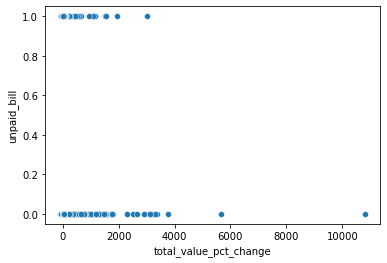

In [406]:
import seaborn as sns
sns.scatterplot(x='total_value_pct_change', y='unpaid_bill', data=merged_data)

In [407]:
# top_10_highest_values = merged_data.nlargest(5, 'TotalVal')
# top_10_highest_values

In [408]:
quintiles = merged_data['TotalVal'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
array_q = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
merged_data['TotalVal_quintile'] = pd.cut(merged_data['TotalVal'], quintiles, labels=array_q)

# Loop through quintiles and run a logistic regression
for quintile in array_q:
    merged_data_quintile = merged_data[merged_data['TotalVal_quintile'] == quintile]
    Xx = merged_data_quintile[['total_value_pct_change', 'median_hh_income','income_gini','pct_white','pct_bachelor','pct_rented']]
    Xx = sm.add_constant(Xx) # adding a constant to include the intercept term
    Yy = merged_data_quintile['unpaid_bill']
    print(f'Coefficients for quintile {quintile}')
    logit = sm.Logit(Yy, Xx)
    result = logit.fit()
    print(result.summary())
    

Coefficients for quintile Q1
Optimization terminated successfully.
         Current function value: 0.420850
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            unpaid_bill   No. Observations:                16394
Model:                          Logit   Df Residuals:                    16387
Method:                           MLE   Df Model:                            6
Date:                Mon, 30 Jan 2023   Pseudo R-squ.:                0.003624
Time:                        13:52:02   Log-Likelihood:                -6899.4
converged:                       True   LL-Null:                       -6924.5
Covariance Type:            nonrobust   LLR p-value:                 4.313e-09
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.5024      0.491     -3.061

In [409]:
#  total unpaid bill rate
parcels['unpaid_bill'].mean()

0.06945540647198106

91224

 --------
Raw totals quintiles:
TaxVal_quintile
(0.0, 164400.0]          2578
(164400.0, 237900.0]     1276
(237900.0, 304300.0]      952
(304300.0, 420200.0]      769
(420200.0, 8505800.0]     749
Name: unpaid_bill, dtype: int64

 --------
Total_counts quintiles:
TaxVal_quintile
(0.0, 164400.0]          17073
(164400.0, 237900.0]     18279
(237900.0, 304300.0]     18223
(304300.0, 420200.0]     18241
(420200.0, 8505800.0]    18233
Name: TaxValue, dtype: int64

 --------
rate raw_counts / total_counts by quintile:
TaxVal_quintile
(0.0, 164400.0]          0.150999
(164400.0, 237900.0]     0.069807
(237900.0, 304300.0]     0.052242
(304300.0, 420200.0]     0.042158
(420200.0, 8505800.0]    0.041079
dtype: float64
TaxVal_quintile        unpaid_bill
(0.0, 164400.0]        False          14495
                       True            2578
(164400.0, 237900.0]   False          17003
                       True            1276
(237900.0, 304300.0]   False          17271
                 

/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/2287866855.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


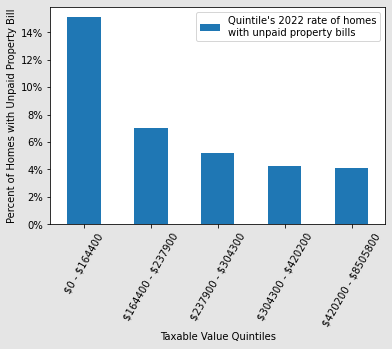

In [410]:
# Here I'm checking to see which quintiles have more unpaid bills.
#switching back to using all parcels to include those I filtered out
#when cleaning for the previous section, but an argument could probably be made to use either.
import matplotlib.pyplot as plt
print(len(parcels))
quintiles = parcels['TaxValue'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
array_q = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
parcels['TaxVal_quintile'] = pd.cut(parcels['TaxValue'], quintiles)


grouped_quintiles = parcels.groupby('TaxVal_quintile')

# Get the raw number of true 'unpaid_bill' variables in each quintile
raw_counts_quintiles = grouped_quintiles['unpaid_bill'].sum()

# Get the total number of records in each quintile
total_counts_quintiles = grouped_quintiles['TaxValue'].count()

# Get the ratio of true 'unpaid_bill' variables in each quintile
ratio_quintiles = raw_counts_quintiles / total_counts_quintiles
print('\n --------')
print('Raw totals quintiles:')
print(raw_counts_quintiles)
print('\n --------')
print('Total_counts quintiles:')
print(total_counts_quintiles)
print('\n --------')
print('rate raw_counts / total_counts by quintile:')
print(ratio_quintiles)

print(parcels.groupby('TaxVal_quintile')['unpaid_bill'].value_counts(dropna=False))
quintiles_rates = parcels.groupby('TaxVal_quintile')['unpaid_bill'].agg(['count', 'sum', 'mean']).reset_index()
fig, ax = plt.subplots(facecolor='#E5E5E5') #set figure background color to a light gray (#E5E5E5)
quintiles_rates.plot.bar(x='TaxVal_quintile', y='mean', rot=0,ax=ax)

x_labels = [f"\${int(i.left)} - \${int(i.right)}" for i in parcels['TaxVal_quintile'].cat.categories]
print(x_labels)
ax.set_xticklabels(x_labels,rotation=60)

ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

ax.legend(["Quintile's 2022 rate of homes\nwith unpaid property bills"]);

plt.xlabel("Taxable Value Quintiles")

plt.ylabel("Percent of Homes with Unpaid Property Bill")



plt.savefig('images/unpaid_property_bill_quintile_rates.png', dpi=300,bbox_inches='tight')

Deciles
 --------
Raw totals:
TaxVal_deciles
(0.0, 105200.0]          1566
(105200.0, 164400.0]     1012
(164400.0, 205200.0]      711
(205200.0, 237900.0]      565
(237900.0, 269300.0]      493
(269300.0, 304300.0]      459
(304300.0, 350200.0]      420
(350200.0, 420200.0]      349
(420200.0, 561300.0]      354
(561300.0, 8505800.0]     395
Name: unpaid_bill, dtype: int64

 --------
Total_counts:
TaxVal_deciles
(0.0, 105200.0]          7952
(105200.0, 164400.0]     9121
(164400.0, 205200.0]     9129
(205200.0, 237900.0]     9150
(237900.0, 269300.0]     9102
(269300.0, 304300.0]     9121
(304300.0, 350200.0]     9123
(350200.0, 420200.0]     9118
(420200.0, 561300.0]     9111
(561300.0, 8505800.0]    9122
Name: TaxValue, dtype: int64

 --------
rate raw_counts / total_counts:
TaxVal_deciles
(0.0, 105200.0]          0.196932
(105200.0, 164400.0]     0.110953
(164400.0, 205200.0]     0.077884
(205200.0, 237900.0]     0.061749
(237900.0, 269300.0]     0.054164
(269300.0, 304300.0]     0

/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/3207939747.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


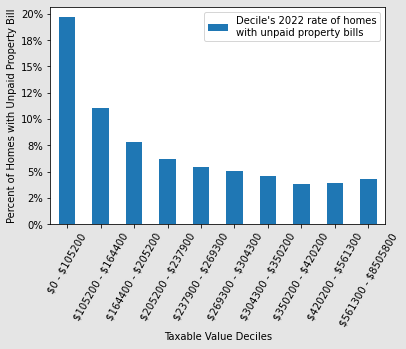

In [411]:
# Doing the same thing here for all deciles
deciles = parcels['TaxValue'].quantile([0,0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1])
parcels['TaxVal_deciles'] = pd.cut(parcels['TaxValue'], deciles)


grouped_deciles = parcels.groupby('TaxVal_deciles')

# Get the raw number of true 'unpaid_bill' variables in each decile
raw_counts_deciles = grouped_deciles['unpaid_bill'].sum()

# Get the total number of records in each decile
total_counts_deciles = grouped_deciles['TaxValue'].count()

# Get the ratio of true 'unpaid_bill' variables in each decile
ratio_deciles = raw_counts_deciles / total_counts_deciles
print('Deciles\n --------')
print('Raw totals:')
print(raw_counts_deciles)
print('\n --------')
print('Total_counts:')
print(total_counts_deciles)
print('\n --------')
print('rate raw_counts / total_counts:')
print(ratio_deciles)

print(parcels.groupby('TaxVal_deciles')['unpaid_bill'].value_counts(dropna=False))
decile_rates=parcels.groupby('TaxVal_deciles')['unpaid_bill'].agg(['count', 'sum', 'mean']).reset_index()


# Modify the x-axis labels




fig, ax = plt.subplots(facecolor='#E5E5E5') #set figure background color to a light gray (#E5E5E5)
decile_rates.plot.bar(x='TaxVal_deciles', y='mean', rot=0,ax=ax)
x_labels = [f"\${int(i.left)} - \${int(i.right)}" for i in parcels['TaxVal_deciles'].cat.categories]
print(x_labels)
ax.set_xticklabels(x_labels,rotation=60)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

ax.legend(["Decile's 2022 rate of homes\nwith unpaid property bills"]);

plt.xlabel("Taxable Value Deciles")

plt.ylabel("Percent of Homes with Unpaid Property Bill")

plt.savefig('images/unpaid_property_bill_decile_rates.png', dpi=300,bbox_inches='tight')

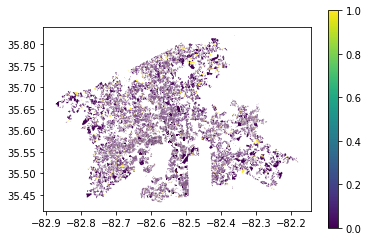

In [412]:
merged_data.plot(column='unpaid_bill',legend=True);

In [413]:
# # https://deckgl.readthedocs.io/en/latest/layer.html#example-vancouver-property-values

# # running this polygon 3d layer map makes this file too big for github


# import pydeck

# crs = {'init': 'epsg:4326'}

# # Convert both parcels and tracts to the same CRS
# merged_data = merged_data.to_crs(crs)

# # Calculate the centroid of disolved parcels
# # https://stackoverflow.com/questions/59979424/pydeck-r-show-outputs-typeerror-vars-argument-must-have-dict-attribute
# merged_data_j = gpd.read_file(merged_data[['geometry','total_value_pct_change','unpaid_bill']].to_json())

# dis_merged_data_centroid = merged_data_j.dissolve().centroid
# # Extract the latitude and longitude of each centroid
# print(float(dis_parcels_centroid.y))
# print(float(dis_parcels_centroid.x))
# INITIAL_VIEW_STATE = pydeck.ViewState(
#   latitude=float(dis_parcels_centroid.y),
#   longitude=float(dis_parcels_centroid.x),
#   zoom=11,
#   max_zoom=16,
#   pitch=45,
#   bearing=0
# )

# geojson = pydeck.Layer(
#     'GeoJsonLayer',
#     data=merged_data_j,
#     opacity=0.8,
#     stroked=False,
#     filled=True,
#     extruded=True,
#     wireframe=True,
    
#     get_elevation='total_value_pct_change',
# #     get_fill_color='unpaid_bill',
#     get_fill_color='unpaid_bill === true ? [225,0,0] : [225,225,0]' ,
# #     get_line_color=[255, 255, 255],
#     get_line_width= 0,
#     pickable=True
# )

# r = pydeck.Deck(
#     layers=[
# #         polygon, 
#         geojson],
#     initial_view_state=INITIAL_VIEW_STATE)





# # r.to_html(filename='unpaid_property_bill_map.html')